In [10]:
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/tracking/')
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/utils/')
from data_loading import *
from hit import Hit
from track3D import Track3D
from track import Track
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import sys
from tqdm import tqdm

plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': [r'\usepackage{amsmath}'],
    'figure.dpi': 140
})


In [11]:
# later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing
file_path = '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/geant4/data_decay3.root'

branch_list = ['E', 'Edep', 'pdg', 'EcalEdep',
               'layerID', 'barID', 'Nhits', 'tx', 'ty', 'x0', 'y0', 'n_sec',
               'ProcessID', 'x_decay', 'y_decay', 'z_decay', 'size_XY', 'size_Z']
with uproot.open(file_path) as tree:
        hits_dict = tree['events'].arrays(branch_list, library="np")

df_hits = pd.DataFrame.from_dict(hits_dict)
og = len(df_hits)
df_hits.query('ProcessID == 0', True)
print('kept {} events containing decays, {:.2f}% of all'.format(len(df_hits), len(df_hits)/og * 100))


kept 100000 events containing decays, 100.00% of all


In [12]:
from parameters import *

def get_hits(row):
    return [[row['barID'][i], row['layerID'][i], row['EcalEdep'][i], row['ProcessID']] for i in range(len(row['barID']))
            if row['EcalEdep'][i] > 0 and not (row['pdg'][i] < 0 or row['pdg'][i] == 406 or row['pdg'][i] == 407)]
    # or row['ProcessID'] == 0

def DetectorCoord(pos):
    x = int(pos[0] / width)
    y = int(pos[1] / width)
    z = int(int(pos[2]) / (thickness + thickness_screen))
    if z % 2 == 0: # a layer measuring the x coordinate
        return True, x, z
    else:
        return False, y, z

def create_tracks(df, plot=False):
    tracks = []
    tags = []
    decay_pos = []
    decay_pos_det = []
    all_hits_x_x = []
    all_hits_x_z = []
    all_hits_y_y = []
    all_hits_y_z = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        hits = get_hits(row)
        if len(hits) > 0:
            hitsX = [Hit([bar, (layer-1)/2 + 1], True, 0, 0, e) for (bar, layer, e, t) in hits if layer % 2 == 1]
            hitsY = [Hit([bar, layer/2 + 1], False, 0, 0, e) for (bar, layer, e, t) in hits if layer % 2 == 0]
            
            # get track parameters
            if len(hitsX) > 0 and len(hitsY) > 0:
                track = Track3D()
                track.x = Track(hitsX)
                track.y = Track(hitsY)
                tracks.append(track)
                tagsX = [tag for (b, layer, e, tag) in hits if layer % 2 == 1]
                tagsY = [tag for (b, layer, e, tag) in hits if layer % 2 == 0]
                tags.append([tagsX, tagsY])
                pos = np.array([row['x_decay'] + row['size_XY']/2, row['y_decay'] + row['size_XY']/2, row['z_decay'] + row['size_Z']/2])
                decay_pos.append(pos)
                decay_pos_det.append(DetectorCoord(pos))
                all_hits_x_x.extend([h.get_pos()[0] for h in track.x.hits])
                all_hits_x_z.extend([h.get_pos()[1] for h in track.x.hits])
                all_hits_y_y.extend([h.get_pos()[0] for h in track.y.hits])
                all_hits_y_z.extend([h.get_pos()[1] for h in track.y.hits])

    return tracks, tags, decay_pos, decay_pos_det, all_hits_x_x, all_hits_x_z, all_hits_y_y, all_hits_y_z


In [13]:
tracks, tags, decay_pos, decay_pos_det, all_hits_x_x, all_hits_x_z, all_hits_y_y, all_hits_y_z = create_tracks(df_hits)
# import line_profiler
# %reload_ext line_profiler
# %lprun -f create_tracks create_tracks(df_hits.head(100))


  0%|          | 0/100000 [00:00<?, ?it/s]/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/tracking/track.py:165: RuntimeWarning: invalid value encountered in double_scalars
  self.reduced_chi2 = self.chi2() / self.n_freedom
/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/tracking/track.py:165: RuntimeWarning: divide by zero encountered in double_scalars
  self.reduced_chi2 = self.chi2() / self.n_freedom
100%|██████████| 100000/100000 [01:49<00:00, 909.53it/s]


####### Track # 4460
decay position = 35.40, 12.44, 6.21
decay hit position = (34.40, 10.20)
max_dist = 20.477


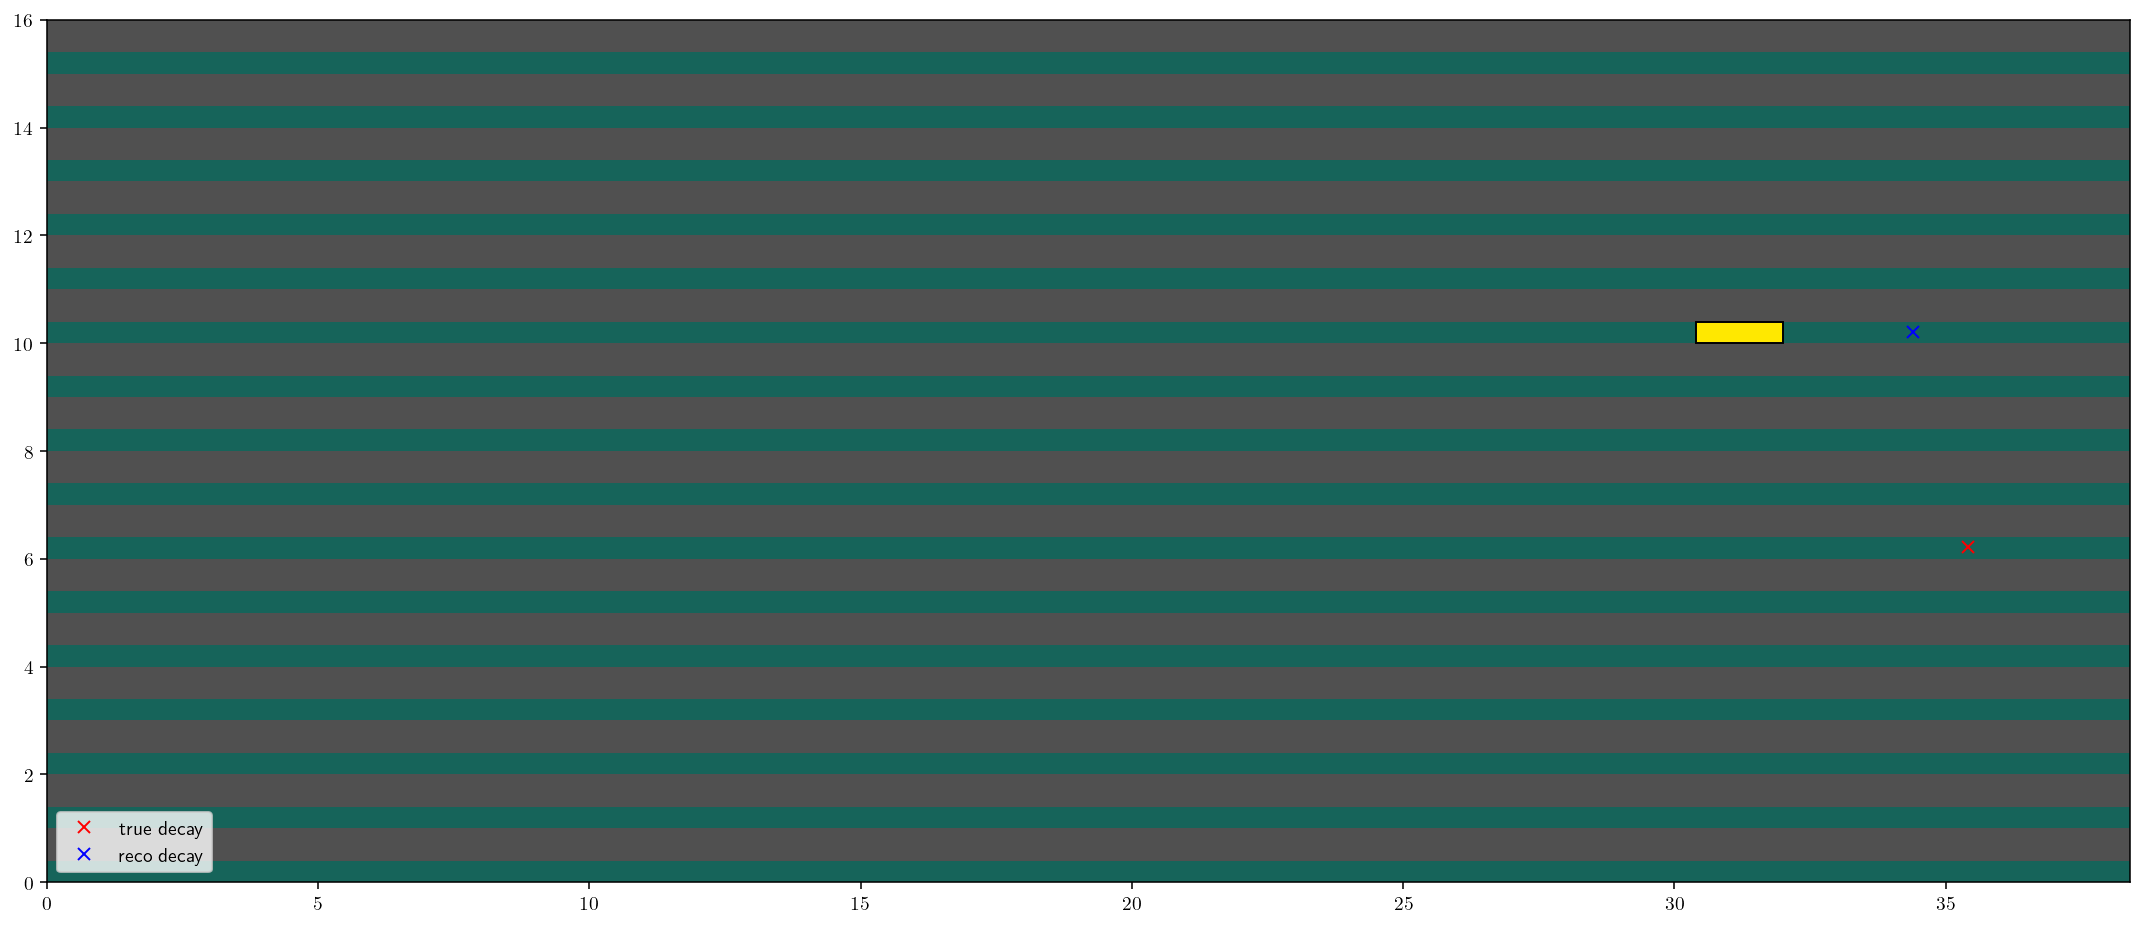

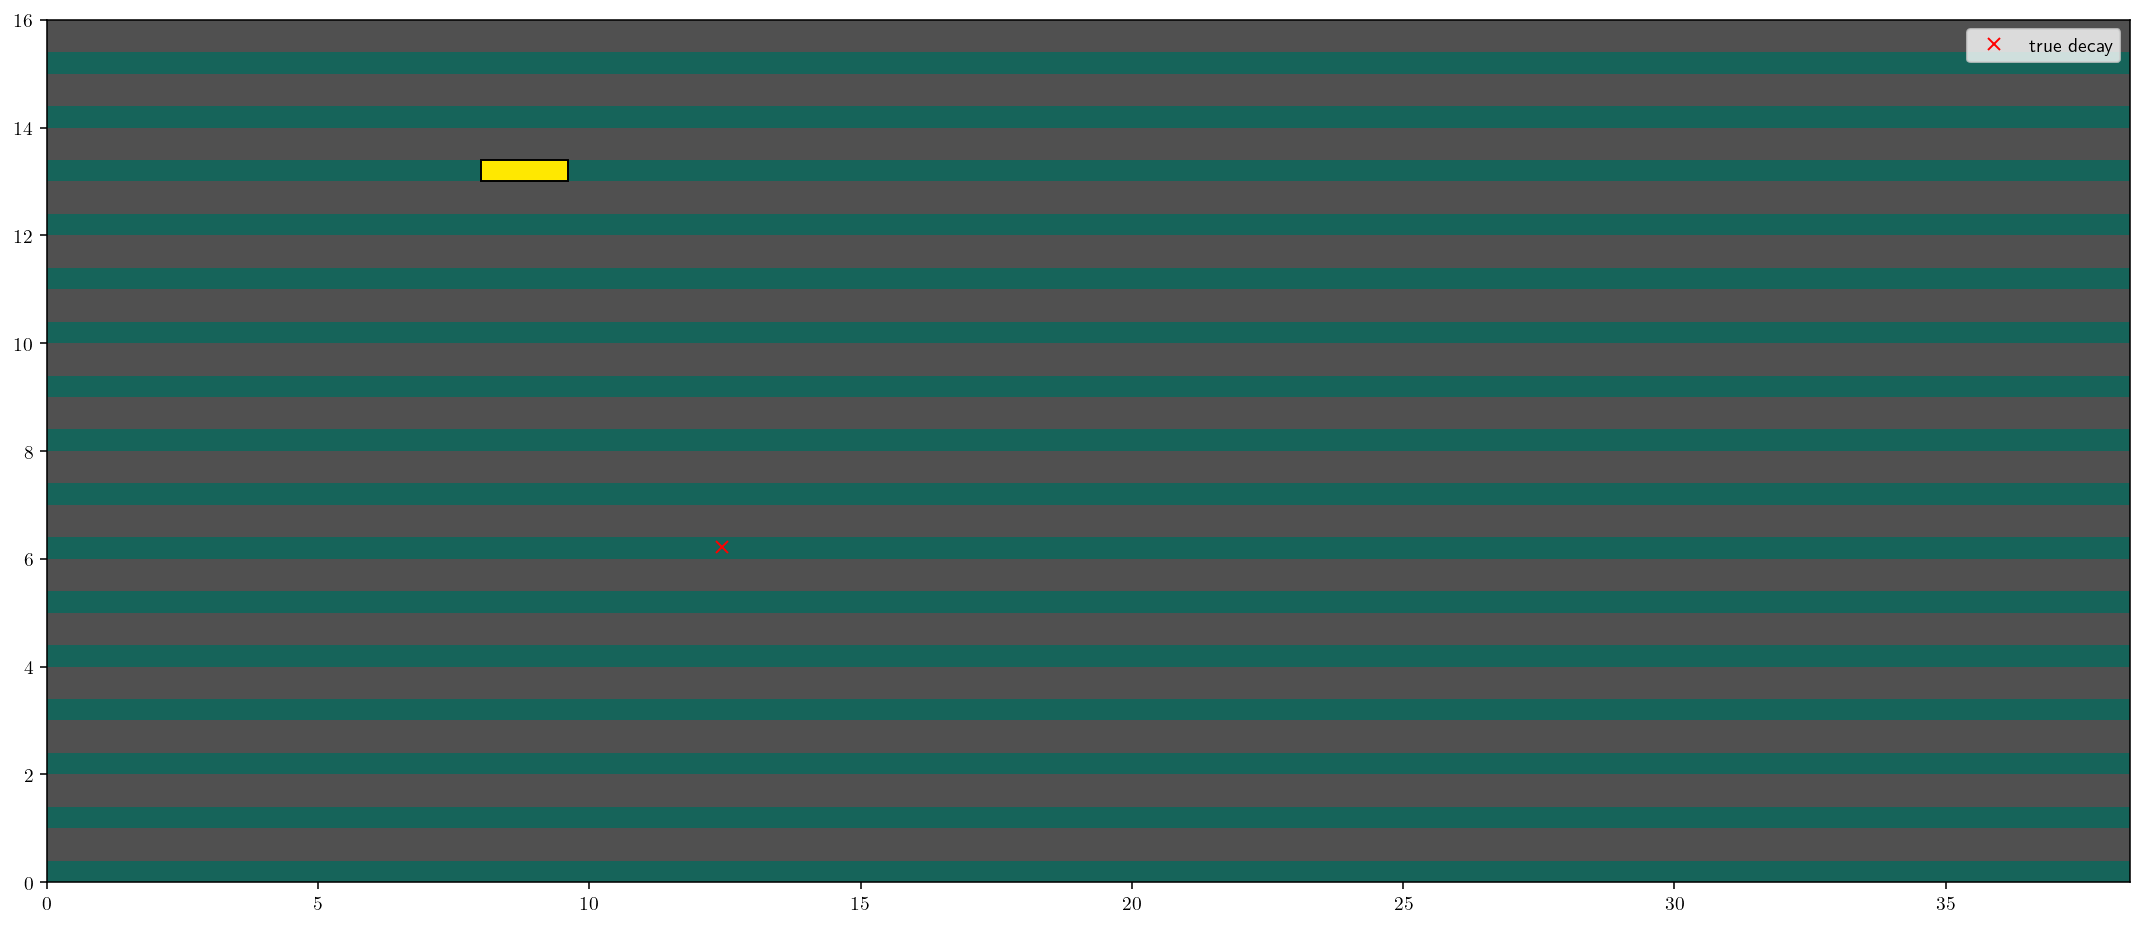

In [14]:
from track_reconstruction import plot_hits
i = np.random.randint(0, len(tracks))
print('####### Track # {}'.format(i))
t = tracks[i]
all_hits = t.x.hits.copy()
all_hits.extend(t.y.hits)
decay_hit = Hit([decay_pos_det[i][1], decay_pos_det[i][2]], decay_pos_det[i][0], 0, 0, 1)
decay_hit_pos = decay_hit.get_pos()
fig1, axs1 = plot_hits(all_hits, True)
fig2, axs2 = plot_hits(all_hits, False)

print('decay position = {:.2f}, {:.2f}, {:.2f}'.format(decay_pos[i][0], decay_pos[i][1], decay_pos[i][2]))
print('decay hit position = ({:.2f}, {:.2f})'.format(decay_hit_pos[0], decay_hit_pos[1]))
axs1.plot([decay_pos[i][0]], [decay_pos[i][2]], 'rx', label='true decay')
axs2.plot([decay_pos[i][1]], [decay_pos[i][2]], 'rx', label = 'true decay')
if decay_pos_det[i][0]:
    axs1.plot([decay_hit_pos[0]], [decay_hit_pos[1]], 'bx', label='reco decay')
else:
    axs2.plot([decay_hit_pos[0]], [decay_hit_pos[1]], 'bx', label='reco decay')
axs1.legend()
axs2.legend()
max_dist = 0
for i in range(len(t.x.hits)):
    diff_z = t.x.hits[i].get_pos()[1] - decay_pos[i][2]
    diff_x = t.x.hits[i].get_pos()[0] - decay_pos[i][0]
    d = np.sqrt( diff_x**2 + diff_z**2 )
    if d > max_dist:
        max_dist = d
for i in range(len(t.y.hits)):
    diff_z = t.y.hits[i].get_pos()[1] - decay_pos[i][2]
    diff_y = t.y.hits[0].get_pos()[0] - decay_pos[i][1]
    d = np.sqrt( diff_y**2 + diff_z**2 )
    if d > max_dist:
        max_dist = d
        
print('max_dist = {:.3f}'.format(max_dist))


tracks: 100%|██████████| 8236/8236 [00:00<00:00, 38169.43it/s]


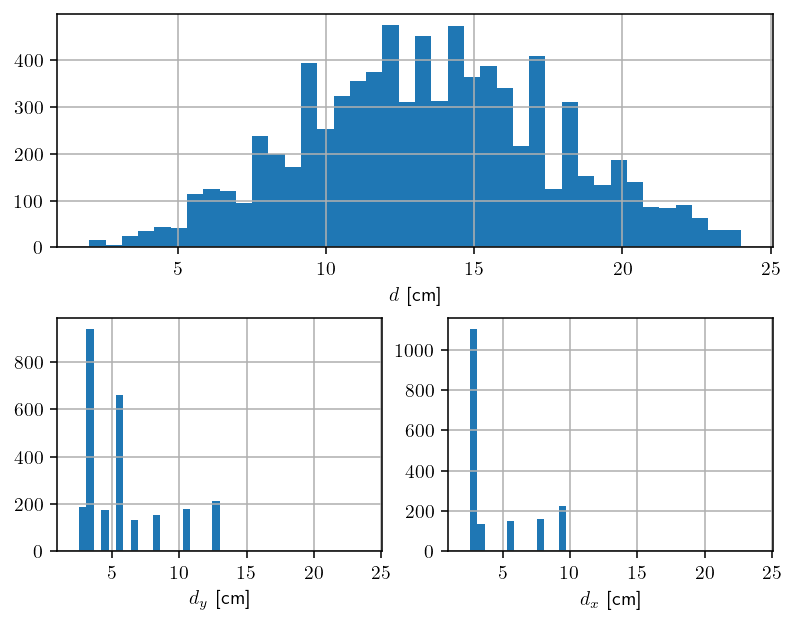

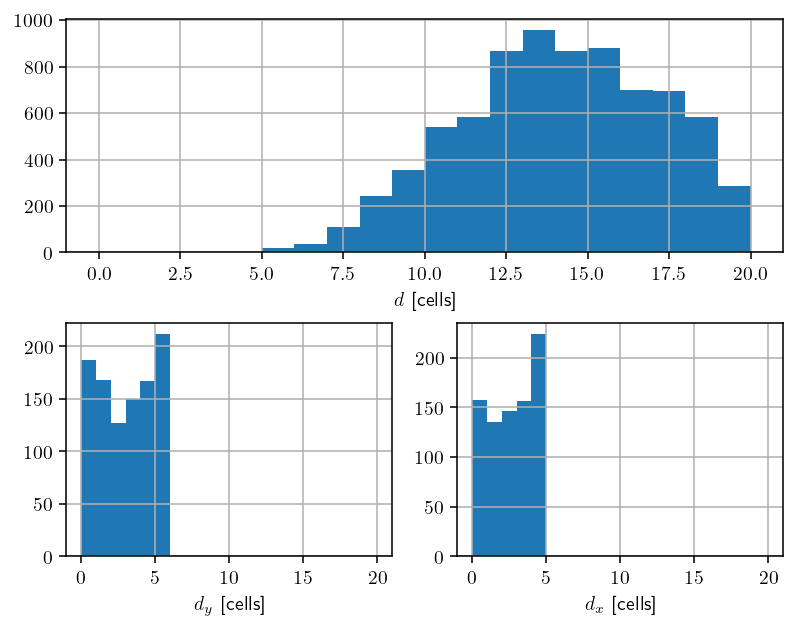

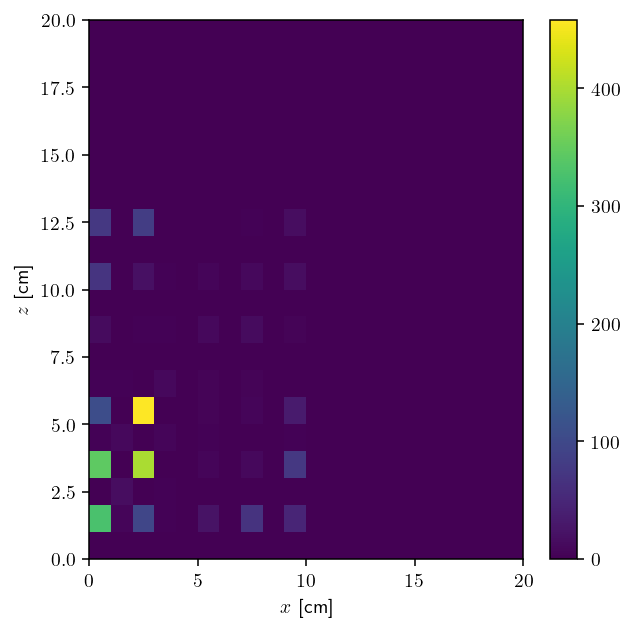

In [21]:
# find max position
maximas = []
maximas_x = []
maximas_y = []
maxi_x_hit = []
maxi_y_hit = []
maxi_hit = []
for t in tqdm(tracks, desc = 'tracks'):
    max_dist = 0
    max_x = 0
    max_y = 0
    max_hit_x = 0
    max_hit_y = 0
    max_hit = 0
    for i in range(len(t.x.hits)):
        diff_z = t.x.hits[i].get_pos()[1] - decay_pos[i][2]
        diff_x = t.x.hits[i].get_pos()[0] - decay_pos[i][0]
        diff_z_hit = t.x.hits[i].coord[1] - decay_pos_det[i][2]
        diff_x_hit = t.x.hits[i].coord[0] - decay_pos_det[i][0]
        d = np.sqrt( diff_x**2 + diff_z**2 )
        d_hit = np.sqrt(diff_z_hit**2 + diff_x_hit**2)  # diff_z_hit #
        if d > max_dist:
            max_dist = d
        if d > max_x:
            max_x = diff_z
        if d_hit > max_hit:
            max_hit = d_hit
        if d_hit > max_hit_x:
            max_hit_x = diff_z_hit
    for i in range(len(t.y.hits)):
        diff_z = t.y.hits[i].get_pos()[1] - decay_pos[i][2]
        diff_y = t.y.hits[0].get_pos()[0] - decay_pos[i][1]
        diff_z_hit = t.y.hits[i].coord[1] - decay_pos_det[i][2]
        diff_y_hit = t.y.hits[i].coord[0] - decay_pos_det[i][1]
        d = np.sqrt( diff_y**2 + diff_z**2 )
        d_hit = np.sqrt(diff_z_hit**2 + diff_y_hit**2)  # diff_z_hit  #
        if d > max_dist:
            max_dist = d
        if d > max_y:
            max_y = diff_z
        if d_hit > max_hit:
            max_hit = d_hit
        if d_hit > max_hit_y:
            max_hit_y = diff_z_hit
    maximas.append(max_dist)
    maximas_x.append(max_x)
    maximas_y.append(max_y)
    maxi_x_hit.append(max_hit_x)
    maxi_y_hit.append(max_hit_y)
    maxi_hit.append(max_hit)
# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

bins = 40

fig = plt.figure()
ax1 = fig.add_subplot(gs[1, 0]) # row 0, col 0
ax1.hist(maximas_y, bins = bins, range = [2, 24])
ax1.set(xlabel = '$d_y$ [cm]')
ax1.grid(True)
ax2 = fig.add_subplot(gs[1, 1]) # row 0, col 1
ax2.hist(maximas_x, bins = bins, range = [2, 24])
ax2.set(xlabel = '$d_x$ [cm]')
ax2.grid(True)
ax3 = fig.add_subplot(gs[0, :]) # row 1, span all columns
ax3.hist(maximas, bins = bins, range = [2, 24])
ax3.set(xlabel = '$d$ [cm]')
ax3.grid(True)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()

bins = 20
fig = plt.figure()
ax1 = fig.add_subplot(gs[1, 0]) # row 0, col 0
ax1.hist(maxi_y_hit, bins=bins, range=[0, 20])
ax1.set(xlabel = '$d_y$ [cells]')
ax1.grid(True)
ax2 = fig.add_subplot(gs[1, 1]) # row 0, col 1
ax2.hist(maxi_x_hit, bins = bins, range = [0, 20])
ax2.set(xlabel = '$d_x$ [cells]')
ax2.grid(True)
ax3 = fig.add_subplot(gs[0, :]) # row 1, span all columns
ax3.hist(maxi_hit, bins=bins, range=[0, 20])
ax3.set(xlabel = '$d$ [cells]')
ax3.grid(True)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
plt.show()

fig, axs = plt.subplots(1, 1, figsize = [5, 5])
h = axs.hist2d(maximas_x, maximas_y, bins = [20, 20], range = [[0, 20], [0, 20]])
axs.plot([np.mean(maximas_x)], [np.mean(maximas_y)], 'rx')
axs.set(xlabel = '$x$ [cm]', ylabel = '$z$ [cm]')
fig.colorbar(h[3], ax = axs)


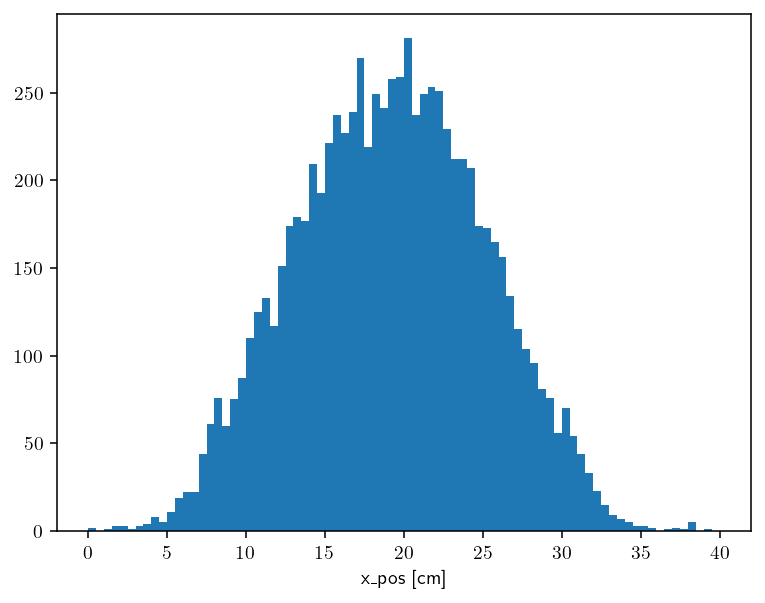

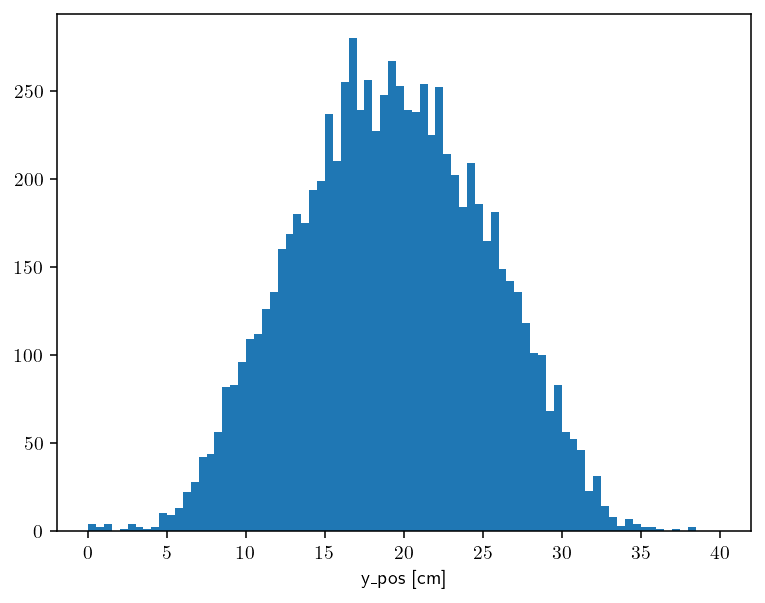

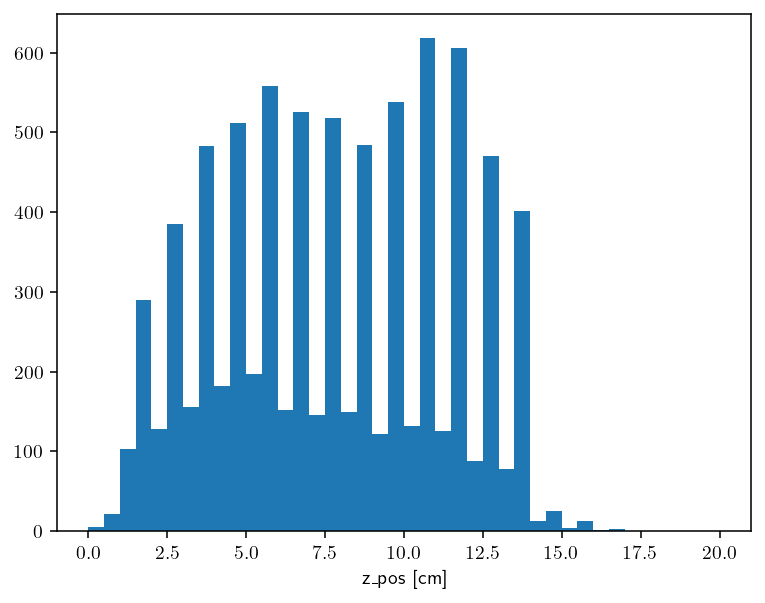

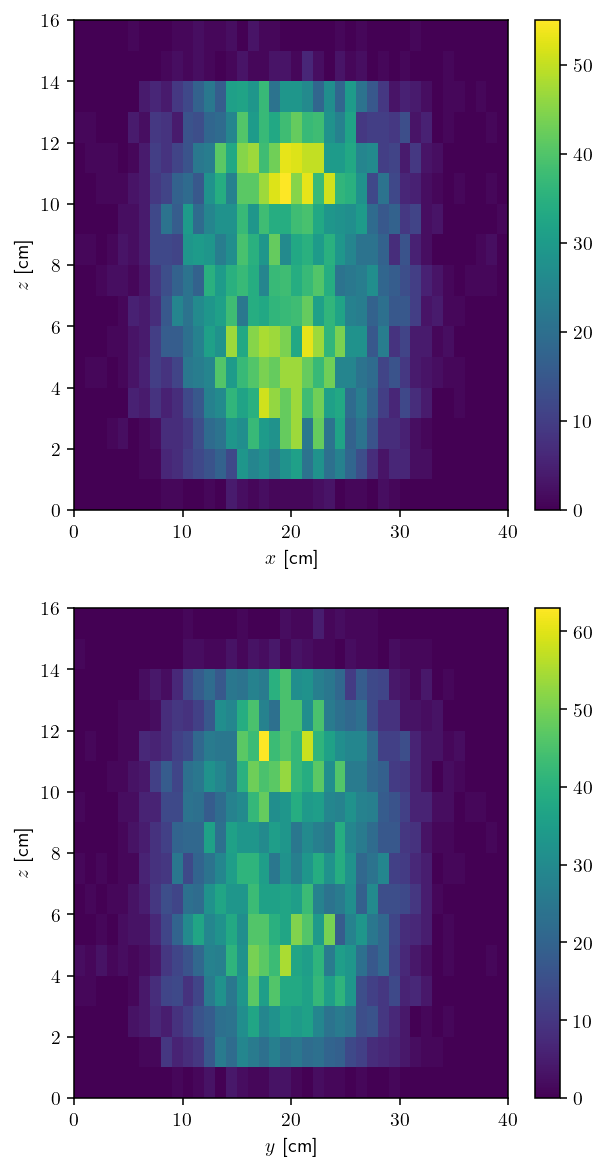

In [16]:
plt.figure()
plt.hist([pos[0] for pos in decay_pos], bins = 80, range = [0, 40])
plt.xlabel('x_pos [cm]')

plt.figure()
plt.hist([pos[1] for pos in decay_pos], bins=80, range = [0, 40])
plt.xlabel('y_pos [cm]')

plt.figure()
plt.hist([pos[2] for pos in decay_pos], bins=40, range = [0, 20])
plt.xlabel('z_pos [cm]')

fig, axs = plt.subplots(2, 1, figsize = [5, 10])
h = axs[0].hist2d([pos[0] for pos in decay_pos], [pos[2] for pos in decay_pos], bins = [40, 16], range = [[0, 40], [0, 16]])
axs[0].set(xlabel = '$x$ [cm]', ylabel = '$z$ [cm]')
fig.colorbar(h[3], ax = axs[0])
h = axs[1].hist2d([pos[1] for pos in decay_pos], [pos[2] for pos in decay_pos], bins = [40, 16], range = [[0, 40], [0, 16]])
axs[1].set(xlabel = '$y$ [cm]', ylabel = '$z$ [cm]')
fig.colorbar(h[3], ax=axs[1])


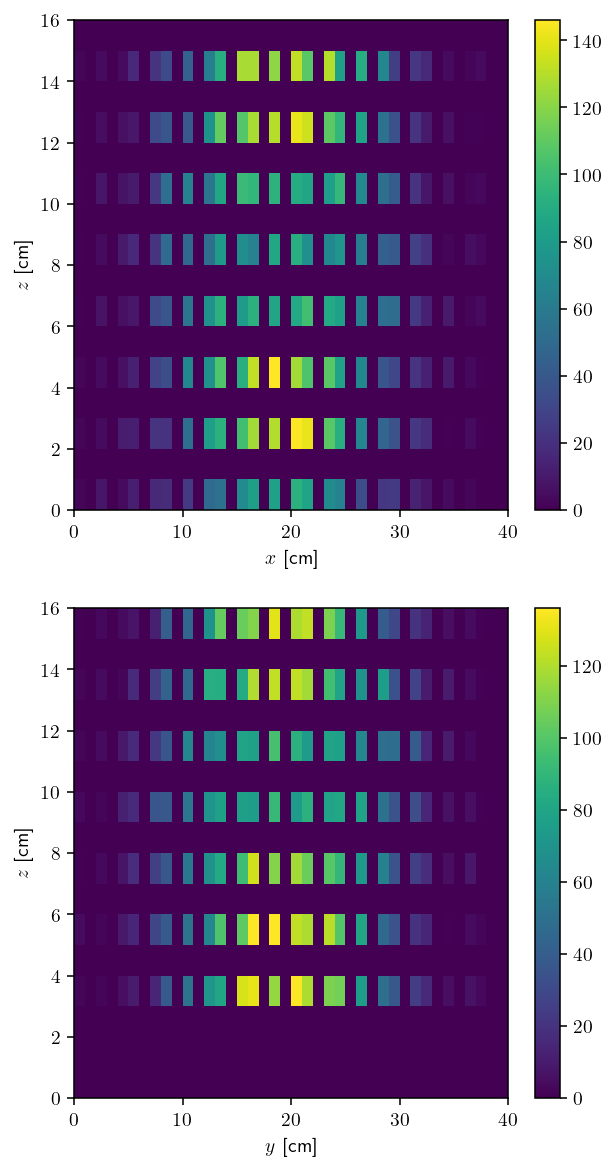

In [17]:
fig, axs = plt.subplots(2, 1, figsize = [5, 10])
h = axs[0].hist2d(all_hits_x_x, all_hits_x_z, bins = [40, 16], range = [[0, 40], [0, 16]])
axs[0].set(xlabel = '$x$ [cm]', ylabel = '$z$ [cm]')
fig.colorbar(h[3], ax = axs[0])
h = axs[1].hist2d(all_hits_y_y, all_hits_y_z, bins = [40, 16], range = [[0, 40], [0, 16]])
axs[1].set(xlabel = '$y$ [cm]', ylabel = '$z$ [cm]')
fig.colorbar(h[3], ax = axs[1])

tracks: 100%|██████████| 8236/8236 [00:00<00:00, 1048671.50it/s]


Text(0.5, 0, '$E_{dep} / MIP$')

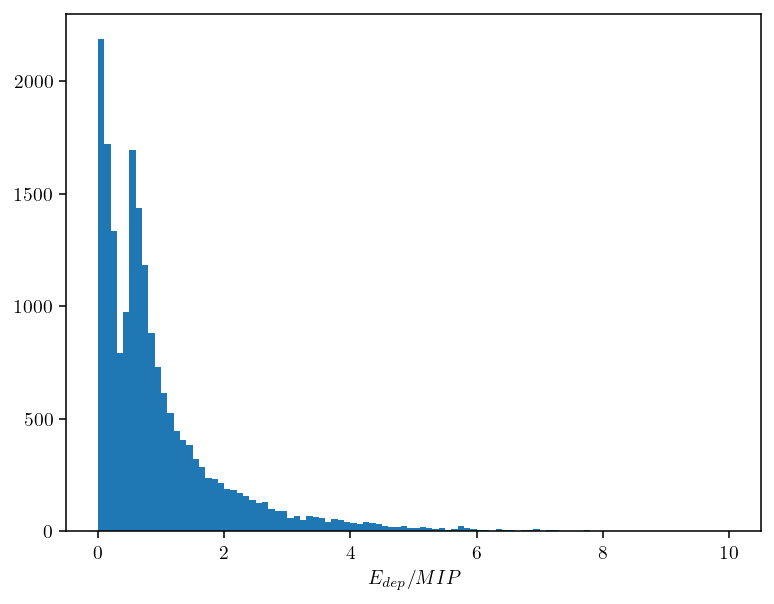

In [18]:
# energy distribution in units of MIPs
edeps = []
for t in tqdm(tracks, desc = 'tracks'):
    edeps.extend([h.value for h in t.x.hits])
    edeps.extend([h.value for h in t.y.hits])
    
edeps = np.array(edeps)
plt.figure()
plt.hist(edeps / 1.32749, bins=100, range=[0, 10], label='data')
plt.xlabel('$E_{dep} / MIP$')
